In [1]:
import findspark
findspark.init('D:/spark-2.3.1-bin-hadoop2.7')
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.functions import desc

In [2]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple('tweets', fields )

In [3]:
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/sparkkafka.stream") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/sparkkafka.stream") \
    .getOrCreate()

sc=my_spark.sparkContext
ssc = StreamingContext(sc, 10 )
socket_stream= ssc.socketTextStream("127.0.0.1",5556)
lines = socket_stream.window(20)
sqlContext = SQLContext(my_spark)
ssc.checkpoint( "D://checkpoint")

#value.decode("utf-8")
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .write.format("com.mongodb.spark.sql.DefaultSource").mode("append").save() ) )#Insert the data into mongodb


In [4]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# Only works for Jupyter Notebooks!
%matplotlib inline

In [5]:
ssc.start()

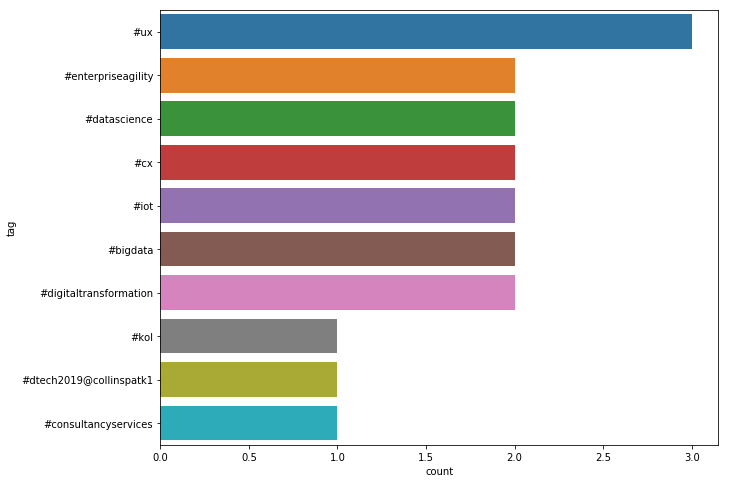

10


In [6]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    #top_10_df.sort(desc("count"))
    #print(top_10_df)
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1
    print (count)